In [1]:
import numpy as np
from keras.datasets import mnist
import keras
from keras.layers import Dense

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# One layer NN

A neural network is an extension of logistic regression that can capture more complexity in the input data. The idea is that a linear function is too weak to capture the complexities of the data, so we should use some sort of nonlinear function. This can be done by taking $u = W_2 g(W_1x)$, for example, which would be a neural network with a single hidden layer. $u$ would then be passed through a softmax function in our case. If $g$ is a nonlinear function, then $u$ can be a nonlinear function of $x$. In addition, if $g$ is differentiable most places, then we can use the chain rule to find $\frac{du}{dW_1}$ and $\frac{du}{dW_2}$. We can also compute $\frac{dL}{du}$ by the chain rule, so then we have $\frac{dL}{dW_1} = \frac{dL}{du} \frac{du}{dW_1}$ by the chain rule (up to a transpose maybe), so we can perform gradient descent here. Although this is a nonconvex function, in practice, gradient descent with a momentum term tends to be fairly effective, and $g$ is often taken to be something like $g(x)=\max(0, x)$, which is a.e. differentiable. 

If we have those parameters, when we compute our errors, by taking the derivative with respect to $\hat{y}$, we get a vector $\frac{dL}{d\hat{y}}$, which is 10 dimensional (say a column vector). Then, we can take $\frac{dL}{du}=\left(\frac{dL}{d\hat{y}}\right)^T \frac{d\hat{y}}{du}$. $\frac{dL}{dW_2} = \frac{dL}{du}\frac{du}{dW_2}$, and $\frac{du}{dW_2}=g(W_1x)$, so this gradient can be computed easily. If we let $v=g(W_1 x)$, $\frac{dL}{dW_1} = \frac{dL}{dv}\frac{dv}{dW_1}$. $\frac{dL}{dv} = \frac{dL}{du}\frac{du}{dv} = W_2^T \frac{dL}{du}$. $\frac{dv}{dW_1} = g'(W_1x)x$, 
so we can plug these two in to compute $\frac{dL}{dW_1}$. With these two gradients, we can take a step of gradient descent.

Note that above I didn't specify the shapes of everything, but there is only one way where the shapes match for everything, in particular if we consider a set of many values of $x$. Then the input is a 2d matrix, so everything only works one way.

In [2]:
(x_train, y_train_orig), (x_test, y_test_orig) = mnist.load_data()
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0
y_train = keras.utils.to_categorical(y_train_orig)
y_test = keras.utils.to_categorical(y_test_orig)

In [3]:
np.random.seed(1151998)
model = keras.models.Sequential()
model.add(Dense(64, input_dim=784, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(keras.optimizers.Adam(), keras.losses.categorical_crossentropy,
             metrics=['accuracy'])

In [4]:
print('%d learnable parameters'%model.count_params())

50890 learnable parameters


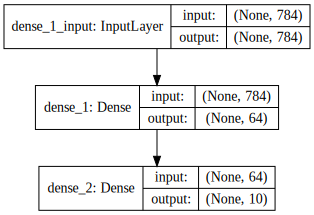

In [5]:
SVG(model_to_dot(model, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [10]:
np.random.seed(1151998)
model.fit(x_train, y_train, epochs=9)

Epoch 1/3
60000/60000 [==============================] - 3s 54us/step - loss: 0.0473 - acc: 0.9857
Epoch 2/3
60000/60000 [==============================] - 3s 53us/step - loss: 0.0393 - acc: 0.9886
Epoch 3/3
60000/60000 [==============================] - 3s 54us/step - loss: 0.0330 - acc: 0.9903


In [14]:
model.load_weights('./super_simple_nn.h5')

In [15]:
print('Test loss: %.4f, Test accuracy: %.4f'%tuple(model.evaluate(x_test, y_test, verbose=0)))

Test loss: 0.0901, Test accuracy: 0.9741


In [16]:
pred_y = model.predict(x_test)

Text(0.5,1,'Confusion Matrix')

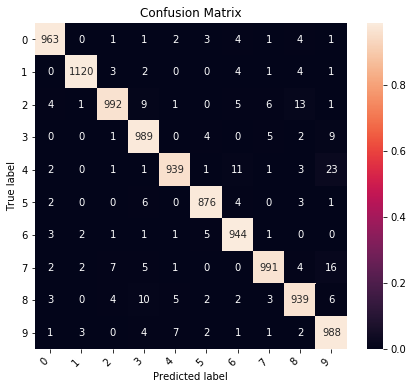

In [17]:
conf_mat = metrics.confusion_matrix(y_test_orig, pred_y.argmax(1))
class_names = list(range(10))
cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(
    cm, index=class_names, columns=class_names, 
)
fig = plt.figure(figsize=(7, 6))
heatmap = sns.heatmap(df_cm, annot=conf_mat, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')